# MnMS Tutorial: Simulation with a Real Network (Lyon 6)

In [1]:
import os
import json

In [15]:
from matplotlib import pyplot as plt

In [29]:
from mnms.simulation import Supervisor
from mnms.demand import CSVDemandManager
from mnms.flow.MFD import Reservoir, MFDFlowMotor
from mnms.time import Time, Dt
from mnms.io.graph import load_graph
from mnms.travel_decision.logit import LogitDecisionModel
from mnms.tools.observer import CSVUserObserver, CSVVehicleObserver
from mnms.generation.layers import generate_matching_origin_destination_layer
from mnms.generation.demand import generate_random_demand
from mnms.mobility_service.personal_vehicle import PersonalMobilityService

### MFD Speed function

In [4]:
def calculate_V_MFD(acc):
    V = 0  # data from fit dsty
    N = acc["CAR"]
    if N < 18000:
        V = 11.5-N*6/18000
    elif N < 55000:
        V = 11.5-6 - (N-18000)*4.5/(55000-18000)
    elif N < 80000:
        V = 11.5-6-4.5-(N-55000)*1/(80000-55000)
    V = max(V, 0.001)  # min speed to avoid gridlock
    return {"CAR": V}

### Load Lyon 6 JSON MnMS Network file

In [8]:
mlgraph = load_graph("lyon6.json")

In [10]:
roads = mlgraph.roads
layers = mlgraph.layers

### Plot nodes

In [13]:
nodes = roads.nodes

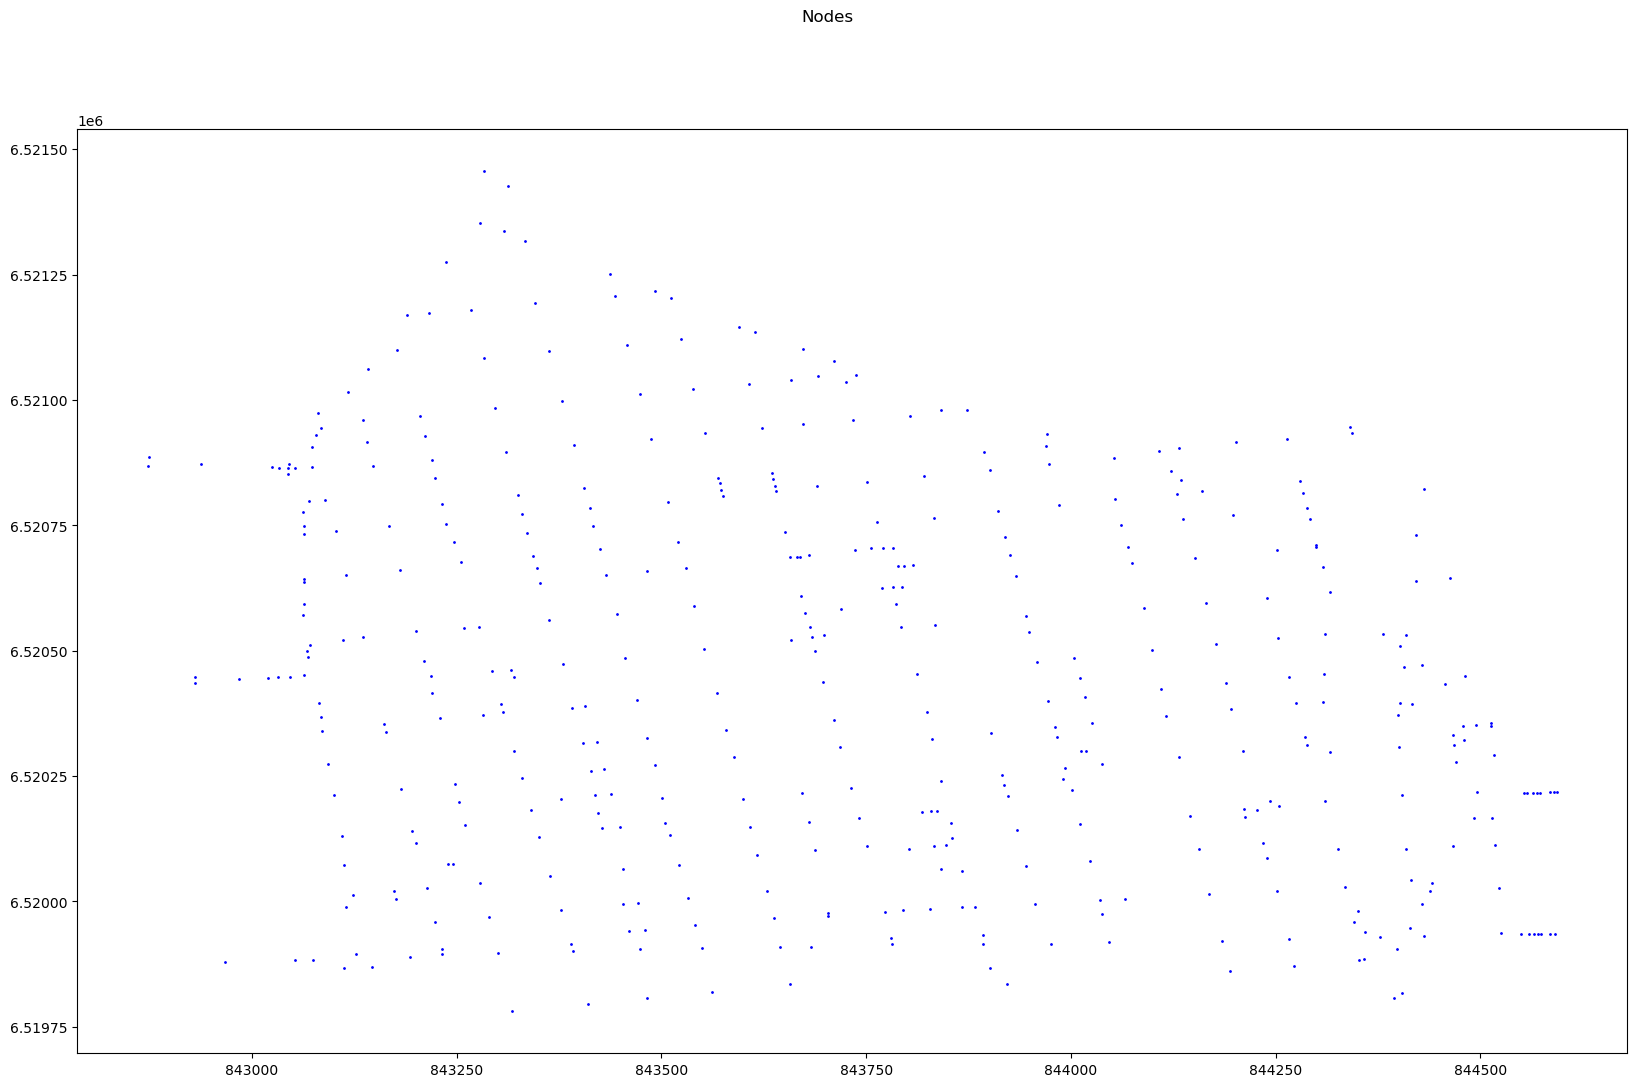

In [17]:
fig_nodes = plt.figure("Nodes", figsize=(20,12))
fig_nodes.suptitle("Nodes")
for id, node in nodes.items():
    x = float(node.position[0])
    y = float(node.position[1])
    plt.scatter(x, y, color="blue", s=1)

### Plot sections

In [18]:
sections = roads.sections

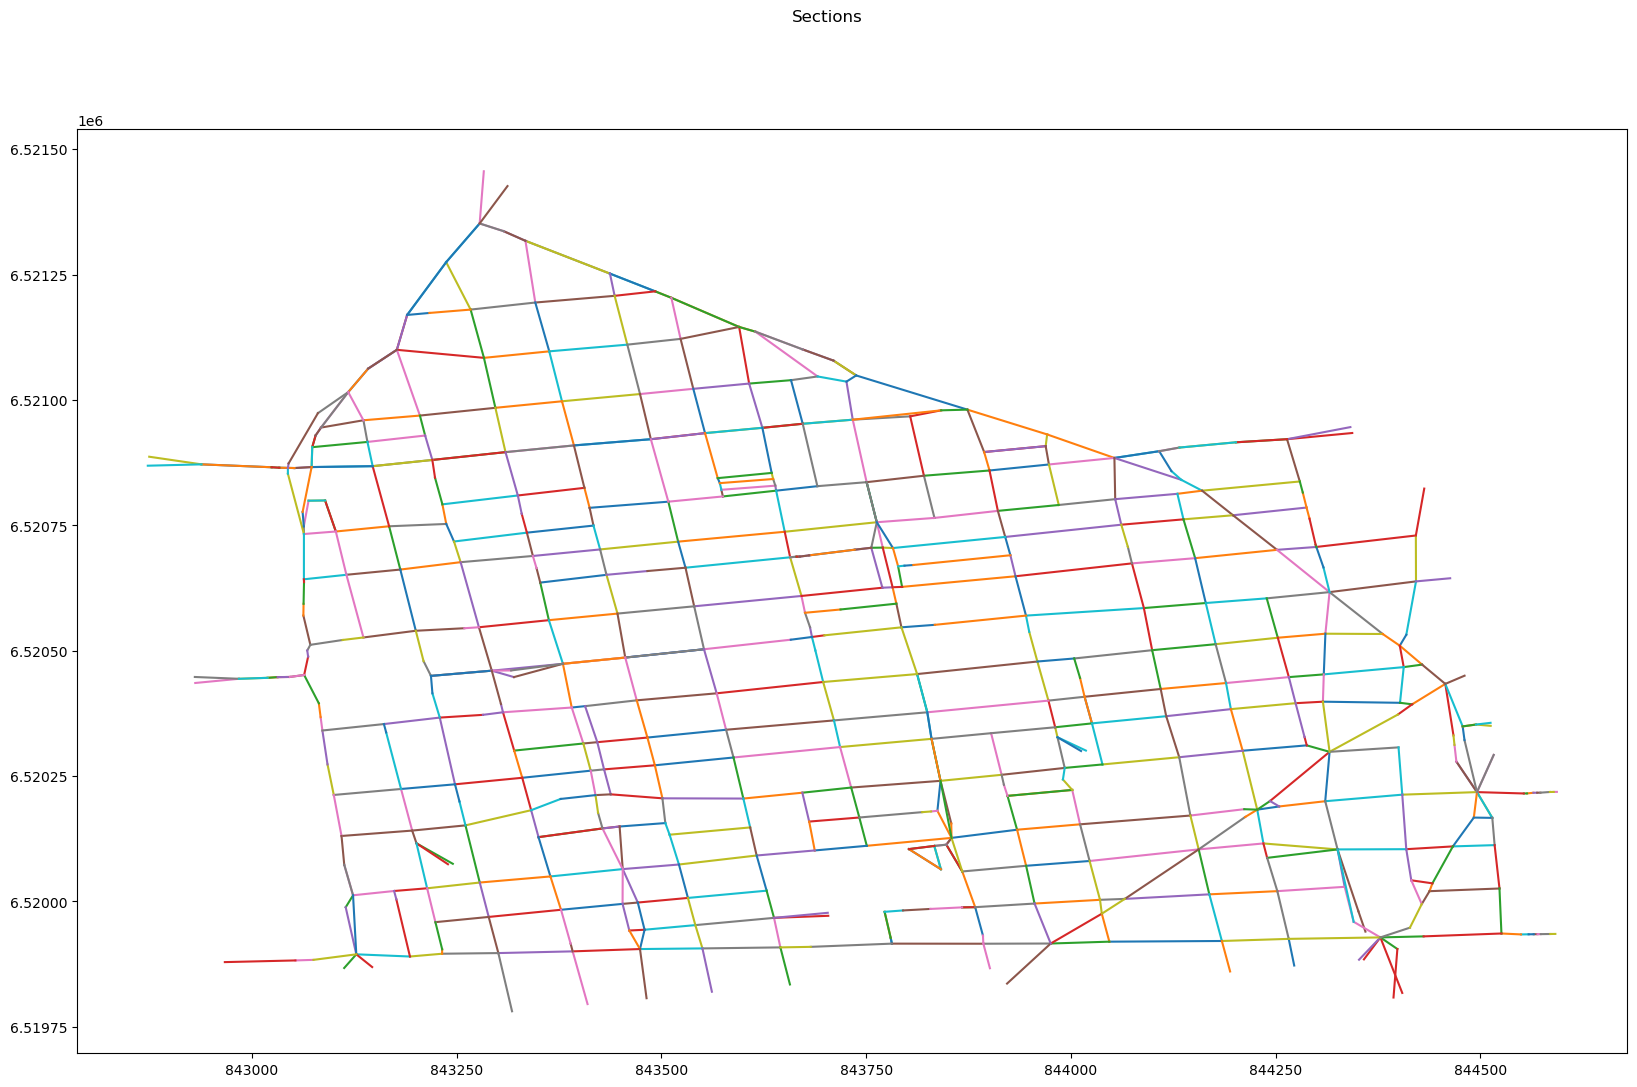

In [19]:
fig_sections = plt.figure("Sections", figsize=(20,12))
fig_sections.suptitle("Sections")
for id, section in sections.items():
    upnode = section.upstream
    downnode = section.downstream

    for id, node in nodes.items():
        if node.id == upnode:
            ux = float(node.position[0])
            uy = float(node.position[1])
        if node.id == downnode:
            dx = float(node.position[0])
            dy = float(node.position[1])

    plt.plot([ux, dx], [uy, dy])

### ODLayer

In [25]:
odlayer = generate_matching_origin_destination_layer(roads)
mlgraph.add_origin_destination_layer(odlayer)

In [26]:
mlgraph.connect_origin_destination_layer(1e-3)

### Mobility Service CAR

In [27]:
personal_car = PersonalMobilityService()
personal_car.attach_vehicle_observer(CSVVehicleObserver("veh.csv"))
layers["CAR"].add_mobility_service(personal_car)

### Demand generation

In [ ]:
demand = generate_random_demand(mlgraph, 100, min_cost=300)

In [ ]:
demand.add_user_observer(CSVUserObserver("user.csv"), user_ids="all")

### Flow Motor

In [ ]:
flow_motor = MFDFlowMotor("flow.csv")
flow_motor.add_reservoir(Reservoir(mlgraph.roads.zones["RES"], ["CAR"], calculate_V_MFD))

### Travel Decision

In [ ]:
travel_decision = LogitDecisionModel(mlgraph, "path.csv")

### Supervisor

In [ ]:
supervisor = Supervisor(graph=mlgraph,
                        flow_motor=flow_motor,
                        demand=demand,
                        decision_model=travel_decision,
                        outfile="travel_time_link.csv")

### Simulation Run

In [ ]:
start_time = "07:00:00"
end_time = "18:00:00"
flow_dt = 1   #minutes
affectation_factor = 10   #minutes

In [ ]:
supervisor.run(Time(start_time), Time(end_time), Dt(minutes=flow_dt), affectation_factor)